In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from madxtools.air_scattering import *
import requests

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [3]:
with open('MWPC_quadrupole_scan_run.pickle', 'rb') as f:
    data = pickle.load(f)

with open('Quadrupole_scan_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

In [4]:
df_quadrupoles.keys()

Index(['timestamp', 'selector', 'avg_flattop_Gauss', 'Ekin', 'Brho', 'current',
       'magnet_name', 'type', 'k1'],
      dtype='object')

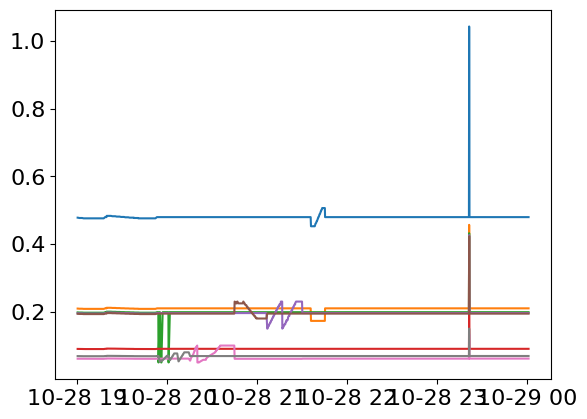

In [5]:
keys = ["F61.QFN007/MEAS.PULSE",
           "F61.QDN014/MEAS.PULSE",
           "F61.QFN021/MEAS.PULSE",
           "F61.QDN030/MEAS.PULSE",
           "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]


fig, ax = plt.subplots()
for key in keys:

    k1 = df_quadrupoles[df_quadrupoles.magnet_name == key].k1
    timestamp = df_quadrupoles[df_quadrupoles.magnet_name == key].timestamp

    ax.plot(timestamp, k1)

In [6]:
data.keys()

Index(['__record_timestamp__', '__record_version__', 'acqMsg', 'acqStamp',
       'acqState', 'acqTime', 'beamID', 'class', 'coincidenceDeviceName',
       'cycleTime', 'cyclestamp', 'device', 'deviceDetailedStatus',
       'deviceHwStatus', 'deviceName', 'equipmentName', 'event', 'gasOk',
       'highVoltage', 'highVoltageMode', 'highVoltageOn', 'highVoltageStatus',
       'inOutPosition', 'moduleWdAcquisition', 'moduleWdMonitor',
       'profileHoriz', 'profileHorizFiltered', 'profileHorizOffset1',
       'profileHorizOffset8', 'profileVert', 'profileVertFiltered',
       'profileVertOffset1', 'profileVertOffset8', 'property', 'selector',
       'superCycleNb', 'wireSpacingHorz', 'wireSpacingVert',
       'nxcals_entity_id', 'timestamp'],
      dtype='object')

In [7]:
selector = "CPS.USER.MD3"

In [8]:
from scipy.optimize import curve_fit

data.sort_values(by="timestamp", inplace=True)

x = np.linspace(93, -93, num=32)

timestamp_list = []
fwhm_list = []

timestamp_listV = []
fwhm_listV = []

# Vectorized function to fit and calculate FWHM
def process_data(y, selector, timestamp_list, fwhm_list, i):
    try:
        popt, pcov = do_gaussian_fit(x, y)
        perrH = np.sqrt(np.diag(pcov))
        if perrH[3] < 5:
            fwhm = abs(fwhm_func(popt[3]))
            timestamp = data[data.selector == selector].timestamp.iloc[i]
            timestamp_list.append(timestamp)
            fwhm_list.append(fwhm)
    except:
        pass

# Process horizontal data
length = len(data[data.selector == selector])-1
for i in range(length):
    y = data[data.selector == selector].profileHoriz.iloc[i]["elements"][0:32]
    process_data(y, selector, timestamp_list, fwhm_list, i)

# Process vertical data
for i in range(length):
    yV = data[data.selector == selector].profileVert.iloc[i]["elements"][0:32]
    process_data(yV, selector, timestamp_listV, fwhm_listV, i)

Text(0.5, 1.0, 'MWPC beam size during RP measurement')

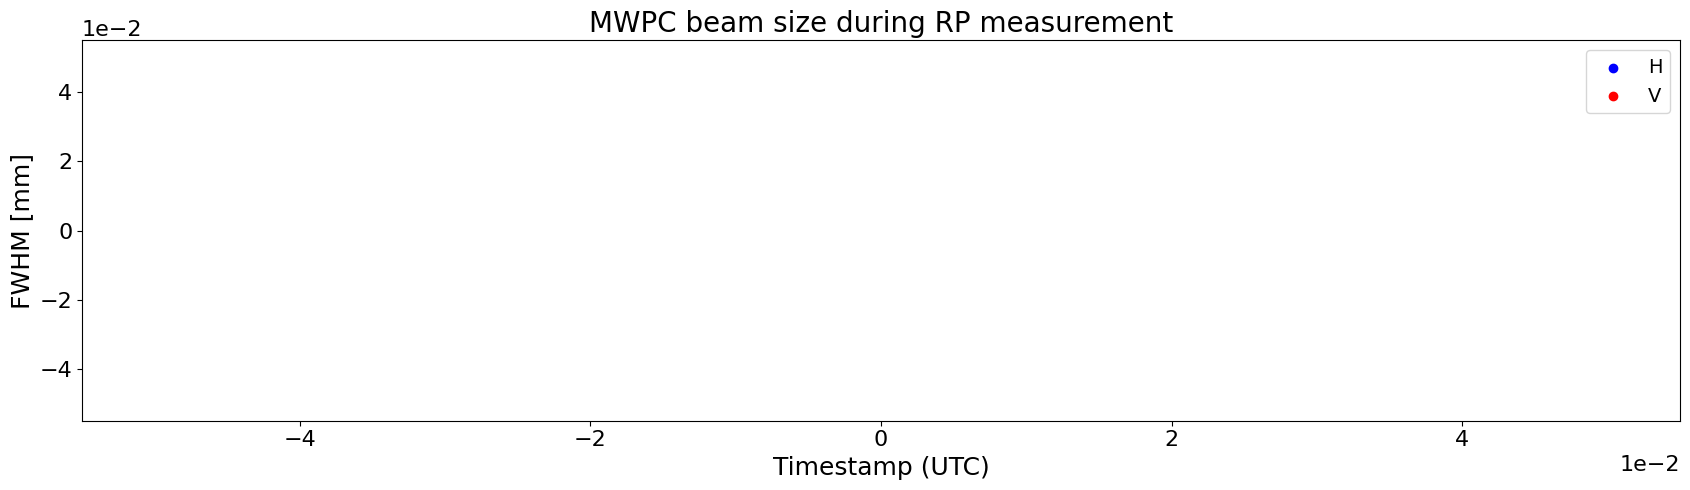

In [9]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, fwhm_list, c="b", label="H")
ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V")

ax.legend()
ax.set_xlabel("Timestamp (UTC)")
ax.set_ylabel("FWHM [mm]")
ax.set_title("MWPC beam size during RP measurement")

# ax.set_xlim(pd.to_datetime('2023-10-31 17:00:00.00'), pd.to_datetime('2023-10-31 19:00:00.00'))

(19658.791666666668, 19659.000694444443)

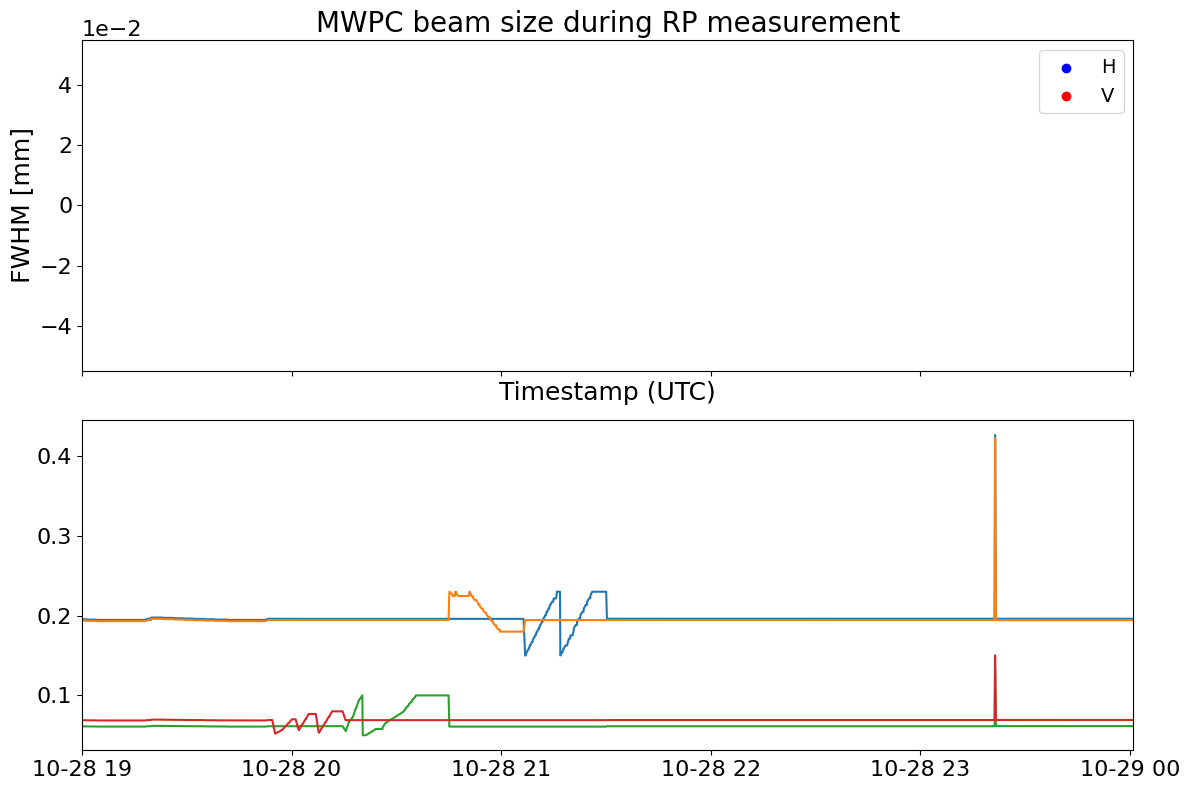

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12,8), tight_layout=True, sharex=True)

ax[0].scatter(timestamp_list, fwhm_list, c="b", label="H")
ax[0].scatter(timestamp_listV, fwhm_listV, c="r", label="V")

ax[0].legend()
ax[0].set_xlabel("Timestamp (UTC)")
ax[0].set_ylabel("FWHM [mm]")
ax[0].set_title("MWPC beam size during RP measurement")

keys = [   "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]
for key in keys:
    k1 = df_quadrupoles[df_quadrupoles.magnet_name == key].k1
    timestamp = df_quadrupoles[df_quadrupoles.magnet_name == key].timestamp
    ax[1].plot(timestamp, k1)

s = "2023-10-28 19:00:00.000"
e = "2023-10-29 00:01:00.000"
ax[1].set_xlim(pd.to_datetime(s), pd.to_datetime(e))
ax[1].set_xlim(pd.to_datetime(s), pd.to_datetime(e))

In [11]:
selector = "CPS.USER.MD3"
target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')

keys = ["F61.QFN007/MEAS.PULSE",
           "F61.QDN014/MEAS.PULSE",
           "F61.QFN021/MEAS.PULSE",
           "F61.QDN030/MEAS.PULSE",
           "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]

quad_k1_at_targ_t = []
for key in keys:
    print(key)
    df_quadrupoles_key = df_quadrupoles[df_quadrupoles.magnet_name == key]

    differences = (df_quadrupoles_key[df_quadrupoles_key.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()
    element = closest_index

    print(df_quadrupoles_key.magnet_name.loc[element])
    print(df_quadrupoles_key.timestamp.loc[element])
    print(df_quadrupoles_key.k1.loc[element])
    quad_k1_at_targ_t.append(df_quadrupoles_key.k1.loc[element])
    print("")
print(quad_k1_at_targ_t)

F61.QFN007/MEAS.PULSE
F61.QFN007/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.47957824997981846

F61.QDN014/MEAS.PULSE
F61.QDN014/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.2100017806556054

F61.QFN021/MEAS.PULSE
F61.QFN021/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.19863661093971197

F61.QDN030/MEAS.PULSE
F61.QDN030/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.0903400848135271

T08.QFN021/MEAS.PULSE
T08.QFN021/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.19607315717478513

T08.QDN023/MEAS.PULSE
T08.QDN023/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.19436926659829545

T08.QDN061/MEAS.PULSE
T08.QDN061/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.06146711515042049

T08.QFN066/MEAS.PULSE
T08.QFN066/MEAS.PULSE
2023-10-29 00:01:00.698238525
0.06914060000511041

[0.47957824997981846, 0.2100017806556054, 0.19863661093971197, 0.0903400848135271, 0.19607315717478513, 0.19436926659829545, 0.06146711515042049, 0.06914060000511041]


# MAD-X T8 with air

In [12]:
E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlim(0,twiss.s[-1])
/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:168: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/madxtools/plot_tool.py:172: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

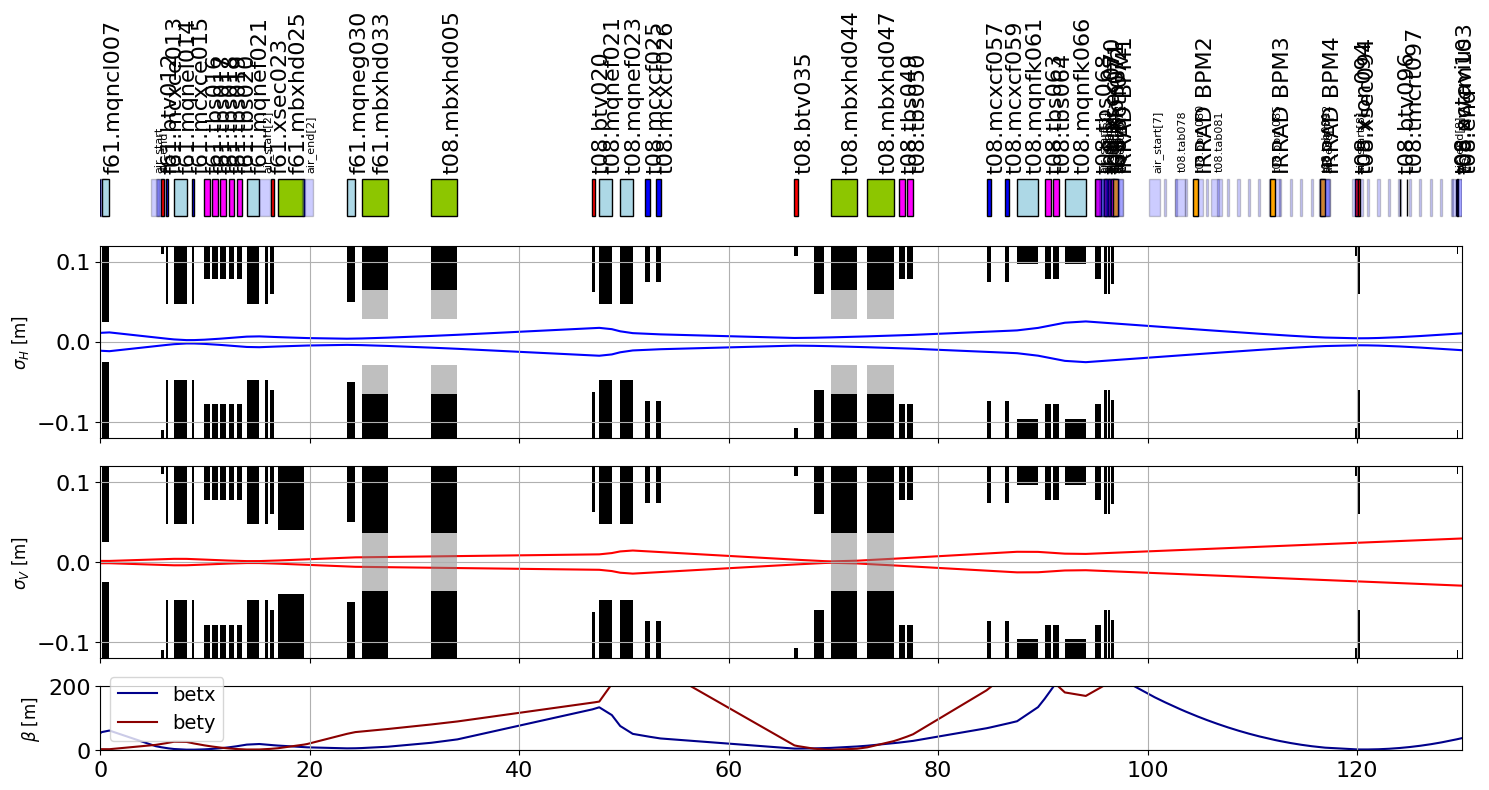

In [13]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
Dx0 = 0.13
Dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
Dy0 = 0.0
Dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)


# Quadrupoles
madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

# Dipoles
madx.input("kBHZ1 = "+str(-0.04821227494)+";")
madx.input("kBHZ2 = "+str(0.04980753404)+";")
madx.input("kBHZ3 = "+str(0.02555487086)+";")
madx.input("kBHZ4 = "+str(-0.03515967369)+";")
madx.input("kBHZ5 = "+str(-0.03515967369)+";")



# Add the Air region
sequence = "f61t8_op"

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


# add_hidden_marker(madx, sequence, 20, 100, steps)

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")



twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="RP_run_3GeV.tfs").dframe()

plot_graph(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1])

In [14]:
madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

In [15]:
twiss.loc['t08.xwcm103']

name       t08.xwcm103:1
keyword          monitor
s             129.659367
betx           35.222215
alfx            -3.65106
               ...      
aper_2               0.0
aper_3               0.0
aper_4               0.0
ex              0.000002
ey              0.000001
Name: t08.xwcm103, Length: 263, dtype: object

In [16]:
sigH = beam_size(twiss_scattered.loc['t08.xwcm103']['betx'], twiss_scattered.loc['t08.xwcm103']['dx'], twiss_scattered.loc['t08.xwcm103'].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc['t08.xwcm103']['bety'], twiss_scattered.loc['t08.xwcm103']['dy'], twiss_scattered.loc['t08.xwcm103'].ey, sige, 1)

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

fwhmH = fwhm_func(sigH)
fwhmV = fwhm_func(sigV)

print(f"{fwhmH*1000:.2f} mm")
print(f"{fwhmV*1000:.2f} mm")

29.59 mm
74.41 mm


In [17]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

In [18]:
data.sort_values(by="timestamp", inplace=True)

In [19]:
data.timestamp[0:10]

989   2023-10-28 19:00:34.001
152   2023-10-28 19:00:41.201
822   2023-10-28 19:01:31.601
129   2023-10-28 19:01:38.801
130   2023-10-28 19:02:29.201
368   2023-10-28 19:02:36.401
765   2023-10-28 19:03:26.801
877   2023-10-28 19:03:34.001
424   2023-10-28 19:04:24.401
241   2023-10-28 19:04:31.601
Name: timestamp, dtype: datetime64[ns]

In [20]:
target_timestamp_list = []
fwhmH_list = []
fwhmV_list = []

iter = 0
for t in data.timestamp:
    print(f"{iter}/{len(data.timestamp)}")
    iter += 1
    selector = "CPS.USER.MD3"
    target_timestamp = t

    keys = ["F61.QFN007/MEAS.PULSE",
            "F61.QDN014/MEAS.PULSE",
            "F61.QFN021/MEAS.PULSE",
            "F61.QDN030/MEAS.PULSE",
            "T08.QFN021/MEAS.PULSE",
            "T08.QDN023/MEAS.PULSE",
            "T08.QDN061/MEAS.PULSE",
            "T08.QFN066/MEAS.PULSE"]

    quad_k1_at_targ_t = []
    for key in keys:
        df_quadrupoles_key = df_quadrupoles[df_quadrupoles.magnet_name == key]

        differences = (df_quadrupoles_key[df_quadrupoles_key.selector == selector].timestamp - target_timestamp).abs()
        closest_index = differences.idxmin()
        element = closest_index
        quad_k1_at_targ_t.append(df_quadrupoles_key.k1.loc[element])

    # Matched initial parameters 10 apr 2024
    betx0 = 6.67479971e+01
    alfx0 = -1.62722259e+01
    Dx0 = 0.08552983
    Dpx0 = 0.01723517
    exn = 2.28304416e-05

    bety0 = 3.76412474e+00
    alfy0 = 7.03346313e-01
    Dy0 = -0.00262435
    Dpy0 = -0.00475684
    eyn = 8.63495536e-06

    sige = 0.0045

    ex = exn/(beta*gamma)
    ex_initial = ex
    ey = eyn/(beta*gamma)
    ey_initial = ey

    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)


    # Quadrupoles
    madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
    madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
    madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
    madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
    madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
    madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
    madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
    madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

    # Dipoles
    madx.input("kBHZ1 = "+str(-0.04821227494)+";")
    madx.input("kBHZ2 = "+str(0.04980753404)+";")
    madx.input("kBHZ3 = "+str(0.02555487086)+";")
    madx.input("kBHZ4 = "+str(-0.03515967369)+";")
    madx.input("kBHZ5 = "+str(-0.03515967369)+";")

    # Add the Air region
    sequence = "f61t8_op"

    p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
    p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
    add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
    p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
    add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

    #t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
    p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
    add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
    add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
    add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
    add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

    pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
    len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
    pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
    add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

    pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
    len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
    pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
    add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


    # add_hidden_marker(madx, sequence, 20, 100, steps)

    madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.use(sequence=sequence)

    madx.input('''
    SEQEDIT, sequence=f61t8_op;
    SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
    REMOVE, ELEMENT=SELECTED;
    ENDEDIT;
    ''')

    # make thin
    madx.use(sequence="f61t8_op")
    madx.input('SEQEDIT, sequence=f61t8_op;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence="f61t8_op")
    madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
    # madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
    madx.use(sequence="f61t8_op")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="RP_run_3GeV.tfs").dframe()

    madx.use(sequence=sequence)
    madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

    sigH = beam_size(twiss_scattered.loc['t08.xwcm103']['betx'], twiss_scattered.loc['t08.xwcm103']['dx'], twiss_scattered.loc['t08.xwcm103'].ex, sige, 1)
    sigV = beam_size(twiss_scattered.loc['t08.xwcm103']['bety'], twiss_scattered.loc['t08.xwcm103']['dy'], twiss_scattered.loc['t08.xwcm103'].ey, sige, 1)

    def fwhm_func(sigma):
            return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

    fwhmH = fwhm_func(sigH)
    fwhmV = fwhm_func(sigV)

    # print(f"{fwhmH*1000:.2f} mm")
    # print(f"{fwhmV*1000:.2f} mm")

    target_timestamp_list.append(t)
    fwhmH_list.append(fwhmH)
    fwhmV_list.append(fwhmV)

0/1062
1/1062
2/1062
3/1062
4/1062
5/1062
6/1062
7/1062
8/1062
9/1062
10/1062
11/1062
12/1062
13/1062
14/1062
15/1062
16/1062
17/1062
18/1062
19/1062
20/1062
21/1062
22/1062
23/1062
24/1062
25/1062
26/1062
27/1062
28/1062
29/1062
30/1062
31/1062
32/1062
33/1062
34/1062
35/1062
36/1062
37/1062
38/1062
39/1062
40/1062
41/1062
42/1062
43/1062
44/1062
45/1062
46/1062
47/1062
48/1062
49/1062
50/1062
51/1062
52/1062
53/1062
54/1062
55/1062
56/1062
57/1062
58/1062
59/1062
60/1062
61/1062
62/1062
63/1062
64/1062
65/1062
66/1062
67/1062
68/1062
69/1062
70/1062
71/1062
72/1062
73/1062
74/1062
75/1062
76/1062
77/1062
78/1062
79/1062
80/1062
81/1062
82/1062
83/1062
84/1062
85/1062
86/1062
87/1062
88/1062
89/1062
90/1062
91/1062
92/1062
93/1062
94/1062
95/1062
96/1062
97/1062
98/1062
99/1062
100/1062
101/1062
102/1062
103/1062
104/1062
105/1062
106/1062
107/1062
108/1062
109/1062
110/1062
111/1062
112/1062
113/1062
114/1062
115/1062
116/1062
117/1062
118/1062
119/1062
120/1062
121/1062
122/1062
123

(0.0, 100.0)

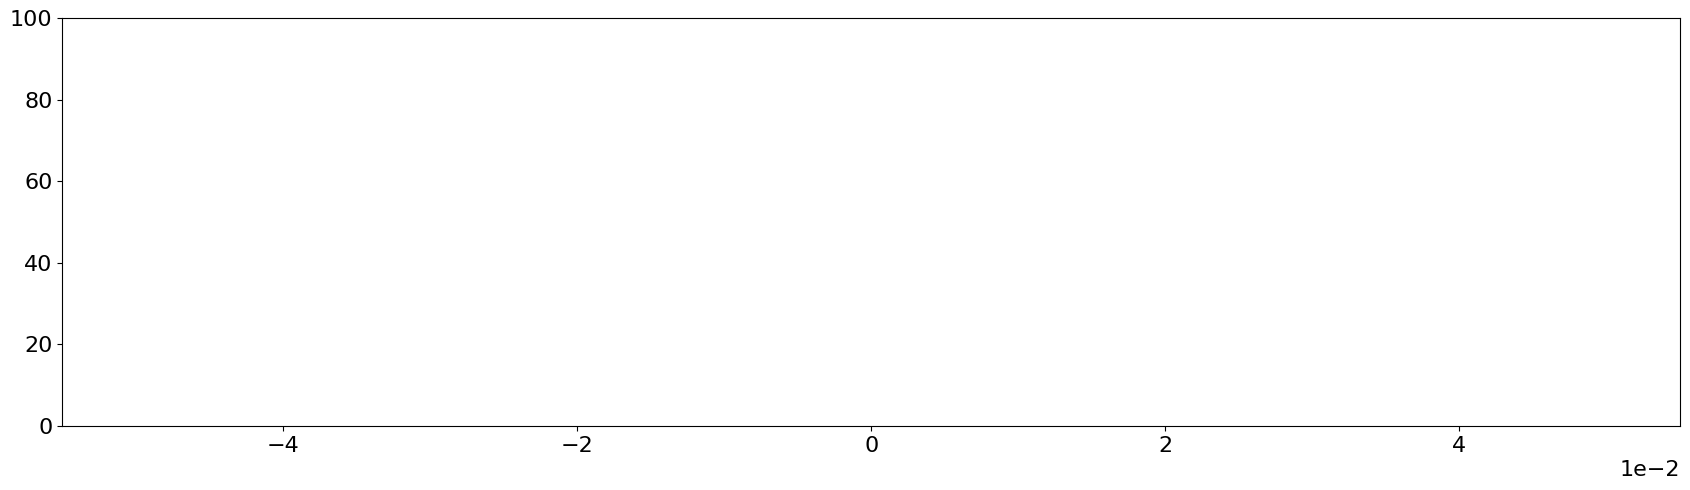

In [21]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, fwhm_list, c="b", label="H", alpha=0.5)
ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V", alpha=0.5)

# ax.scatter(target_timestamp_list, np.array(fwhmH_list)*1000, c="darkblue", label="H")
# ax.scatter(target_timestamp_list, np.array(fwhmV_list)*1000, c="darkred", label="V")

ax.set_ylim(0,100)

(0.0, 100.0)

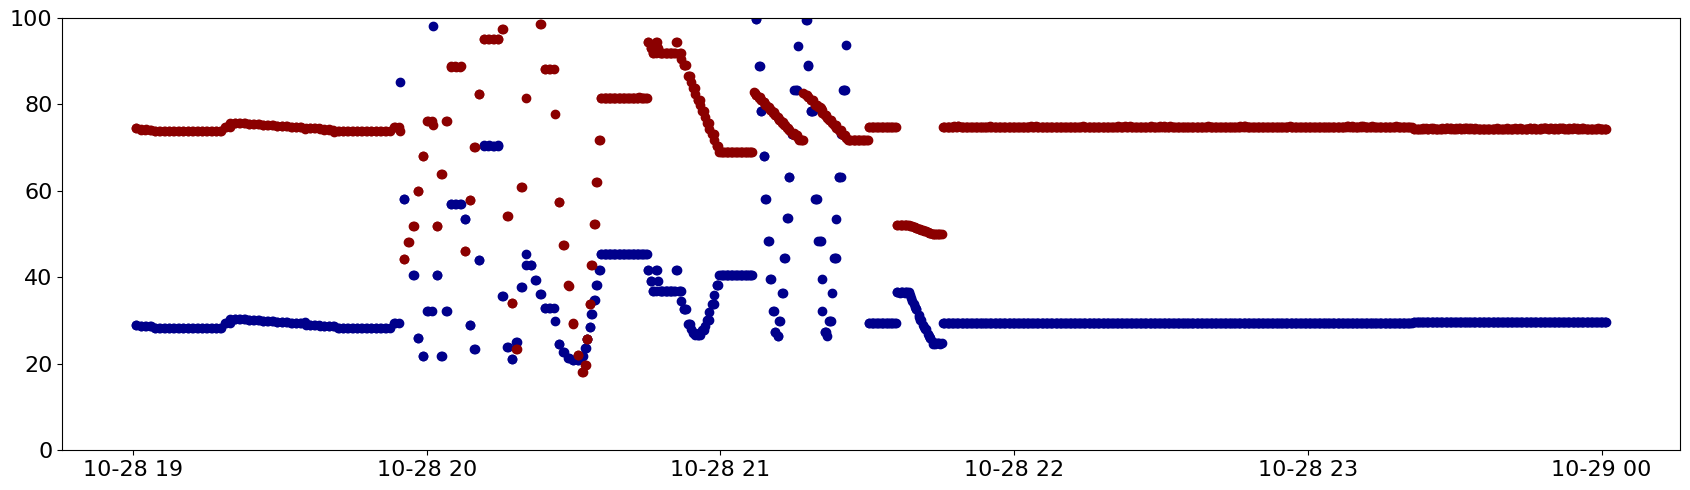

In [22]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, fwhm_list, c="b", label="H", alpha=0.5)
ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V", alpha=0.5)

ax.scatter(target_timestamp_list, np.array(fwhmH_list)*1000, c="darkblue", label="H")
ax.scatter(target_timestamp_list, np.array(fwhmV_list)*1000, c="darkred", label="V")

ax.set_ylim(0,100)

(19658.847222222223, 19658.86111111111)

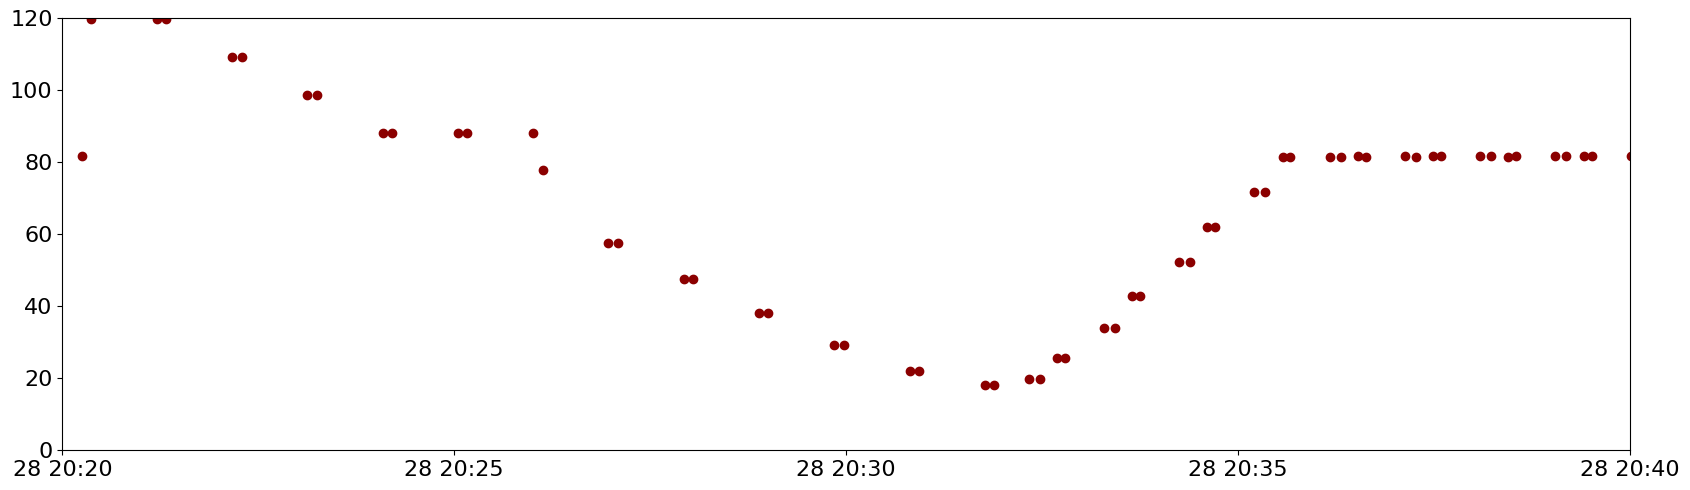

In [23]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

# ax.scatter(timestamp_list, fwhm_list, c="b", label="H", alpha=0.5)
ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V", alpha=0.5)

# ax.scatter(target_timestamp_list, np.array(fwhmH_list)*1000, c="darkblue", label="H")
ax.scatter(target_timestamp_list, np.array(fwhmV_list)*1000, c="darkred", label="V")

ax.set_ylim(0,120)

ax.set_xlim(pd.to_datetime('2023-10-28 20:20:00.00'), pd.to_datetime('2023-10-28 20:40:00.00'))

(19658.875, 19658.895833333332)

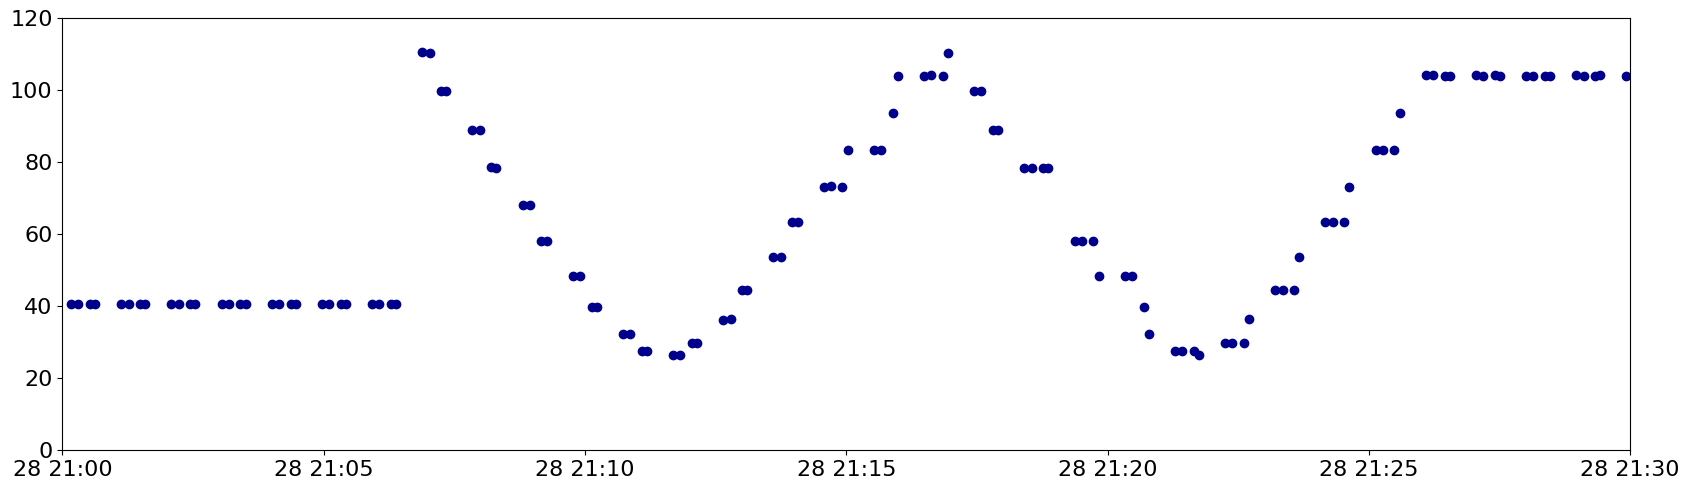

In [24]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, fwhm_list, c="b", label="H", alpha=0.5)
# ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V", alpha=0.5)

ax.scatter(target_timestamp_list, np.array(fwhmH_list)*1000, c="darkblue", label="H")
# ax.scatter(target_timestamp_list, np.array(fwhmV_list)*1000, c="darkred", label="V")

ax.set_ylim(0,120)

ax.set_xlim(pd.to_datetime('2023-10-28 21:00:00.00'), pd.to_datetime('2023-10-28 21:30:00.00'))

In [25]:
print(timestamp_listV[0])

IndexError: list index out of range

In [ ]:
data.keys()

Index(['__record_timestamp__', '__record_version__', 'acqMsg', 'acqStamp',
       'acqState', 'acqTime', 'beamID', 'class', 'coincidenceDeviceName',
       'cycleTime', 'cyclestamp', 'device', 'deviceDetailedStatus',
       'deviceHwStatus', 'deviceName', 'equipmentName', 'event', 'gasOk',
       'highVoltage', 'highVoltageMode', 'highVoltageOn', 'highVoltageStatus',
       'inOutPosition', 'moduleWdAcquisition', 'moduleWdMonitor',
       'profileHoriz', 'profileHorizFiltered', 'profileHorizOffset1',
       'profileHorizOffset8', 'profileVert', 'profileVertFiltered',
       'profileVertOffset1', 'profileVertOffset8', 'property', 'selector',
       'superCycleNb', 'wireSpacingHorz', 'wireSpacingVert',
       'nxcals_entity_id', 'timestamp'],
      dtype='object')

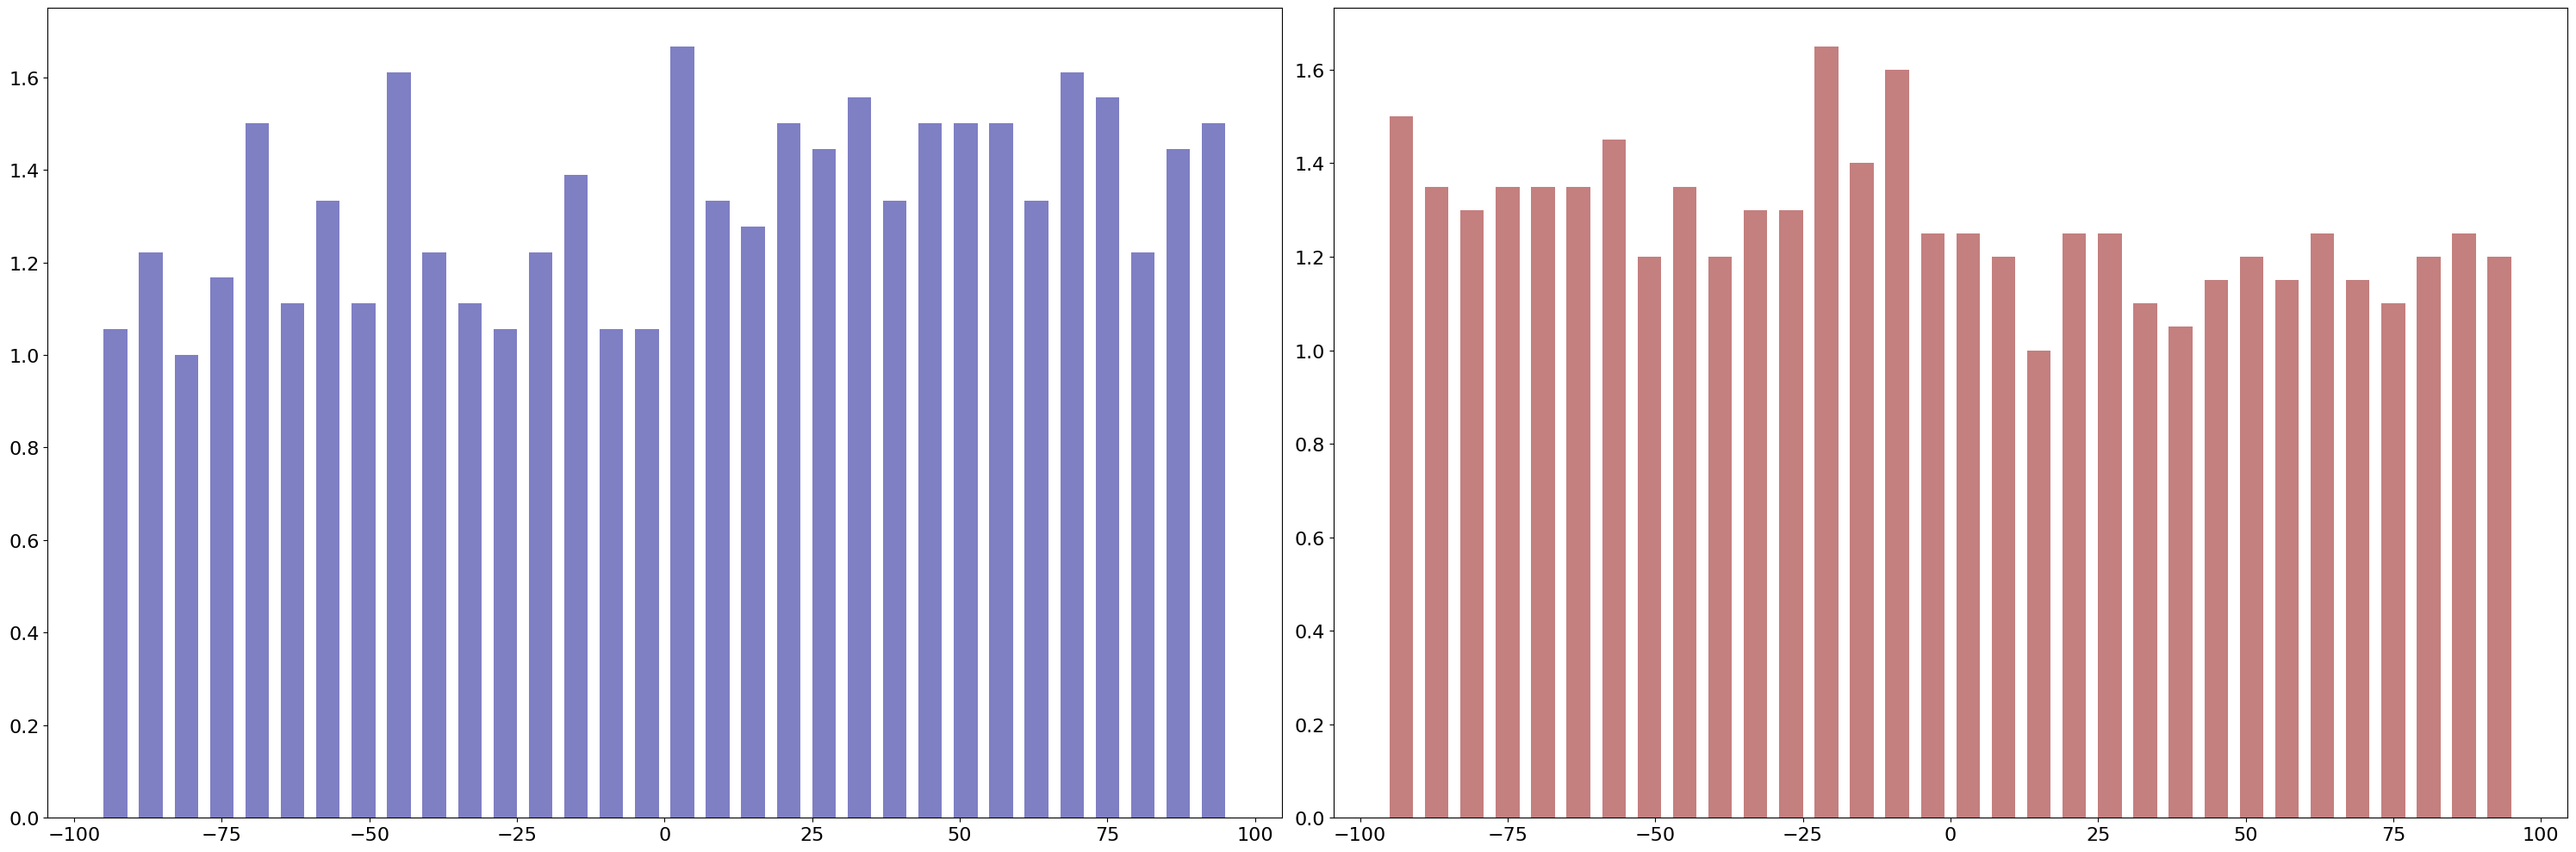

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(1,2, figsize=(30, 10), tight_layout=True)


target_timestamp = pd.to_datetime('2023-10-28 21:15:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)


data[data.selector == selector].timestamp.loc[element]

timestamp_measurement = data[data.selector == selector].timestamp.loc[element]

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax[0].bar(MWPC_wire, y/y.max(), width=4, color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
ax[0].plot(xs=MWPC_wire, ys=np.ones(len(MWPC_wire))*MWPC_wire.max(), zdir='z', c="b", ls="dashed", label=f"H FWHM = {fwhm_func(popt[3]):.1f} mm")

sigH_measurement = popt[3]

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax[1].bar(MWPC_wire, y/y.max(), width=4, color="darkred", alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
ax[1].plot(xs=np.ones(len(MWPC_wire))*MWPC_wire.min(), ys=MWPC_wire, c="r", ls="dashed", label=f"V FWHM = {fwhm_func(poptV[3]):.1f} mm")

sigV_measurement = poptV[3]


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

timestampH_list = []
timestampV_list = []
sigH_measurement_list = []
sigV_measurement_list = []
sigH_error_list = []
sigV_error_list = []

for timestamp in data.timestamp:

    target_timestamp = timestamp
    differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()
    element = closest_index
    MWPC_wire = np.linspace(93, -93, num=32)
    # data[data.selector == selector].timestamp.loc[element]
    timestamp_measurement = data[data.selector == selector].timestamp.loc[element]
    

    # Horizontal Measurement and Gaussian Fit
    try:
        y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
        popt, pcov = do_gaussian_fit(MWPC_wire, y)
        y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
        sigH_measurement = popt[3]
        sigH_measurement_list.append(sigH_measurement)
        perr = np.sqrt(np.diag(pcov))
        sigH_error_list.append(perr[3])
        timestampH_list.append(data[data.selector == selector].timestamp.loc[element])
    except:
        pass

    # Vertical Measurement and Gaussian Fit
    try:
        y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
        poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
        y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
        sigV_measurement = poptV[3]
        sigV_measurement_list.append(sigV_measurement)
        perrV = np.sqrt(np.diag(pcovV))
        sigV_error_list.append(pcovV[3])
        timestampV_list.append(data[data.selector == selector].timestamp.loc[element])
    except:
        pass


In [ ]:
def sigma_func(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, sigma_func(fwhm_list), c="b", label="H", alpha=0.5)
# ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V", alpha=0.5)

ax.scatter(target_timestamp_list, np.array(sigma_func(fwhmH_list))*1000, c="darkblue", label="H")
# ax.scatter(target_timestamp_list, np.array(fwhmV_list)*1000, c="darkred", label="V")

ax.set_ylim(0,120)

ax.set_xlim(pd.to_datetime('2023-10-28 21:00:00.00'), pd.to_datetime('2023-10-28 21:30:00.00'))

ax.errorbar(timestampH_list, sigH_measurement_list, sigH_error_list, ls="", marker="o", markersize=1)

NameError: name 'plt' is not defined